# **SyriaTel Customer churn**
Author:Sheilla Kavinya Muli


The main problem is that SyriaTel is losing money when customers leave unexpectedly.
The objective is to build a machine learning classifier to predict which customers are at risk of leaving before they cancel, allowing the support team to intervine


Success Metric- The models will be optimized for recall. This is because in this business case, missing a chuner (false negative) is costly. The preference is that it cathes all pontential churners, even if it means flagging a few happy customers by mistake.

This is the approach that is used in this note book.
1. Data cleanning and EDA
2. Data preprocessing
3. Iterative modelling

4. Reccommendations

In [3]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3



print ("Libraries imported successfuly!")

Libraries imported successfuly!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Getting the data
#Direction on where the data set is

file_path = "/content/drive/MyDrive/dsc_phase3 project/syriatel.csv /syriatel.csv"
#load into pandas
df = pd.read_csv("/content/drive/MyDrive/dsc_phase3 project/syriatel.csv /syriatel.csv")
#push to sql
conn = sqlite3.connect(':memory:')
df.to_sql("churn_data", conn, index=False, if_exists="replace")

print("Success")

Success


**DATA CLEANING**

In [6]:

#check for missing values
print("Miisng values per column")
print(df.isnull().sum())
print("\n" + "="*30 +"\n")

Miisng values per column
state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64




In [7]:
#checking for duplicates
query_duplicates = """
SELECT "phone number" , COUNT(*)
FROM churn_data
GROUP BY 'phone number'
HAVING COUNT(*) > 1
"""
duplicates = pd.read_sql(query_duplicates, conn)

print("--- Duplicate Phone Numbers ---")
if duplicates.empty:
    print("Great news! The table is empty, meaning NO duplicates found.")
else:
    print(duplicates)

--- Duplicate Phone Numbers ---
  phone number  COUNT(*)
0     382-4657      3333


Tried to use SQL to figure out duplicates. The method did not work because it showed that all users had the same number which was not possible. So i resorted to using pandas.

In [8]:
#Using pandas to get the duplicates
print("Firat 5 rows")
print(df.head())
#print("\n" + "="*30 +"\n")

unique_phones = df['phone number'].nunique()
print(f"\nTotal Unique Phone Numbers: {unique_phones}")
print(f"Total Rows in Data: {len(df)}")


duplicates_count = df.duplicated(subset=['phone number']).sum()
print(f"Number of Duplicates found by Pandas: {duplicates_count}")


Firat 5 rows
  state  account length  ...  customer service calls  churn
0    KS             128  ...                       1  False
1    OH             107  ...                       1  False
2    NJ             137  ...                       0  False
3    OH              84  ...                       2  False
4    OK              75  ...                       3  False

[5 rows x 21 columns]

Total Unique Phone Numbers: 3333
Total Rows in Data: 3333
Number of Duplicates found by Pandas: 0


Data exploration

In [9]:
#preview the data
q1= """
SELECT *
FROM churn_data
LIMIT 5
"""
pd.read_sql(q1, conn)
#

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [10]:
#Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
#update SQL database with new names
df.to_sql("churn_data", conn, index=False, if_exists="replace")
#check new name
print ("New names")
print(df.columns.tolist())

New names
['state', 'account_length', 'area_code', 'phone_number', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'customer_service_calls', 'churn']


International plan
- It is common for people who have international plans to leave if they are not using it yet they are paying a lot of money for it or if the service is bad.
I am going to look though if this is true in this case.

In [11]:
#churn rate for international plan holders
query = """
SELECT
    international_plan,
    COUNT(*) as total_people,
    SUM(churn) as people_who_left,
    CAST (SUM(churn) AS FLOAT) / COUNT(*) * 100 AS churn_rate
FROM churn_data
GROUP BY international_plan
"""
df_intl = pd.read_sql(query, conn)
print(df_intl)




  international_plan  total_people  people_who_left  churn_rate
0                 no          3010              346   11.495017
1                yes           323              137   42.414861


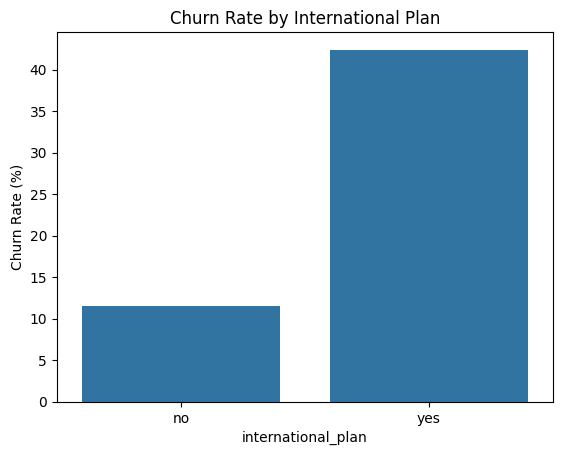

In [12]:
#visuals for above
sns.barplot(x='international_plan', y='churn_rate', data=df_intl)
plt.title('Churn Rate by International Plan')
plt.ylabel("Churn Rate (%)")
plt.show()


This graph shows that customers with international plans are much more likely to leave than those who do not.

Additionally, could it be possible that people do not leave because of a plan but they leave because they had a problem, called for help and did not get it resolved.

In [13]:
#churn rate by number of customer service calls
query_cs = """
SELECT
    customer_service_calls,
    COUNT(*) as total_customers,
    SUM(churn) as churned_customers,
    CAST (SUM(churn)AS FLOAT) /COUNT(*) *100 AS churn_rate
FROM churn_data
GROUP BY customer_service_calls
ORDER BY customer_service_calls
"""
df_cs = pd.read_sql(query_cs, conn)
print(df_cs)


   customer_service_calls  total_customers  churned_customers  churn_rate
0                       0              697                 92   13.199426
1                       1             1181                122   10.330229
2                       2              759                 87   11.462451
3                       3              429                 44   10.256410
4                       4              166                 76   45.783133
5                       5               66                 40   60.606061
6                       6               22                 14   63.636364
7                       7                9                  5   55.555556
8                       8                2                  1   50.000000
9                       9                2                  2  100.000000


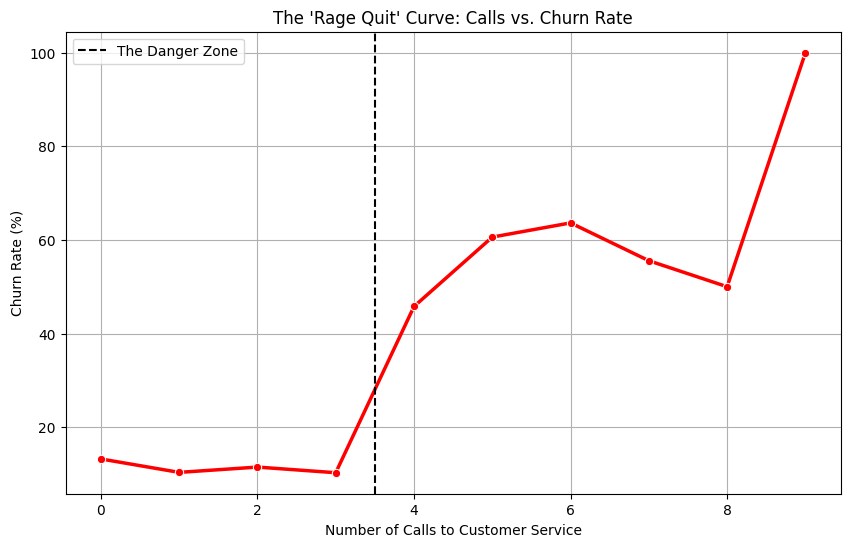

In [14]:
#visuals to show the tipping point of when clients leave
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cs, x="customer_service_calls", y="churn_rate", marker="o", color="red", linewidth=2.5)
plt.title("The 'Rage Quit' Curve: Calls vs. Churn Rate")
plt.xlabel("Number of Calls to Customer Service")
plt.ylabel("Churn Rate (%)")
plt.grid(True)

plt.axvline(x=3.5, color='black', linestyle='--', label="The Danger Zone") # Visual guide
plt.legend()
plt.show()

Preparing data to go into the model
- Final preprocessing and splitting


In [14]:
from os import X_OK
#model one
from sklearn.model_selection import train_test_split

#defining feature x and target y
x = df.drop(columns=['churn', 'state' , 'area_code'])
y = df['churn']

#data spliting
#test=0.2
X_train, X_test, y_train, y_test = train_test_split (x, y, test_size=0.2, random_state=42, stratify=y)

print ("Split successfull")
print(f"Training set: {X_train.shape[0]} rows")
print (f"Test set: {X_test.shape[0]} rows")

Split successfull
Training set: 2666 rows
Test set: 667 rows


# Model building


**Linear regression**

No non-numeric columns found

Logistic Regression model...

--- Baseline model (Logistic regression) ---
              precision    recall  f1-score   support

       False       0.87      0.97      0.92       570
        True       0.42      0.11      0.18        97

    accuracy                           0.85       667
   macro avg       0.64      0.54      0.55       667
weighted avg       0.80      0.85      0.81       667



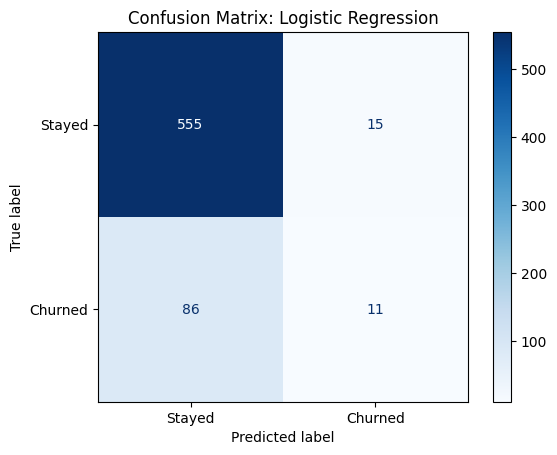

In [16]:
#logistic regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd

#drop non numeric columns
cols_to_drop = X_train.select_dtypes(include=['object']).columns
if len(cols_to_drop) > 0:
    print(f"Dropping non numeric columns: {cols_to_drop.tolist()}")
    X_train = X_train.drop(columns=cols_to_drop)
    X_test = X_test.drop(columns=cols_to_drop)
    print ("Non-numeric columns dropped")
else:
    print ("No non-numeric columns found")
    X_train_clean = X_train.copy()
    X_test_clean = X_test.copy()

#scale the clean data

scaler =StandardScaler()
scaler.fit(X_train_clean)
#transform both trsining and test data
X_train_scaled = scaler.transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

#convert back to data frame - use x_train_clean.columns to match the shape
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_clean.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_clean.columns)


#model training
print("\nLogistic Regression model...")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

#model testing
y_pred_log = log_reg.predict(X_test_scaled)

#model evaluation
print("\n--- Baseline model (Logistic regression) ---")
print (classification_report(y_test, y_pred_log))

#confussion matrix to show how many chaners were actaually caught
cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stayed", "Churned"])
disp.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

The Logistic Regression model achieved high overall accuracy, but this is misleading. The Recall for the Churn class is only 0.11, meaning the model failed to identify 89% of at-risk customers. Because our business goal is to catch churners before they leave, this model is not useful. We need a model that can handle non-linear patterns (like the 4 calls rule) and the class imbalance.

**Decision tree**


Decision Tree model...

--- Decision Tree model results ---
              precision    recall  f1-score   support

       False       0.93      0.93      0.93       570
        True       0.58      0.57      0.57        97

    accuracy                           0.88       667
   macro avg       0.75      0.75      0.75       667
weighted avg       0.88      0.88      0.88       667



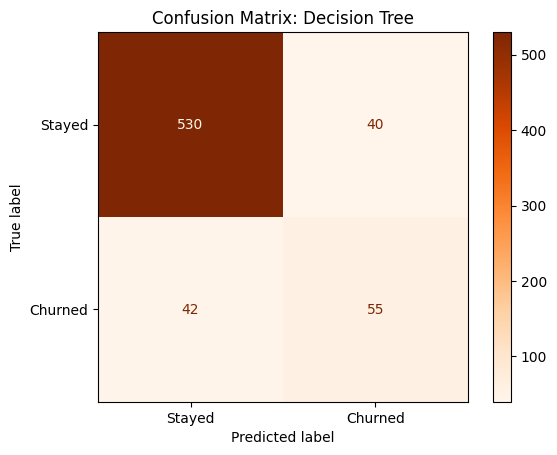

In [18]:
from sklearn.tree import DecisionTreeClassifier

#Train the tree
# class_weight='balanced' forces the model to pay more attention to the minority class (Churners)
# max_depth=5 keeps the tree simple enough to interpret
print("\nDecision Tree model...")
clf_tress = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5)
clf_tress.fit(X_train_scaled, y_train)

#now i predict
y_pred_tree = clf_tress.predict(X_test_scaled)

#then model evaluation
print("\n--- Decision Tree model results ---")
print(classification_report(y_test, y_pred_tree))

#visulas of the confusion matrix
cm = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stayed", "Churned"])
disp.plot(cmap='Oranges')
plt.grid(False)
plt.title("Confusion Matrix: Decision Tree")
plt.show()


**Tuned tree**

Tuning the model...
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5}

--- Final tuned model results ---
              precision    recall  f1-score   support

       False       0.80      0.01      0.01       570
        True       0.15      0.99      0.25        97

    accuracy                           0.15       667
   macro avg       0.47      0.50      0.13       667
weighted avg       0.70      0.15      0.05       667



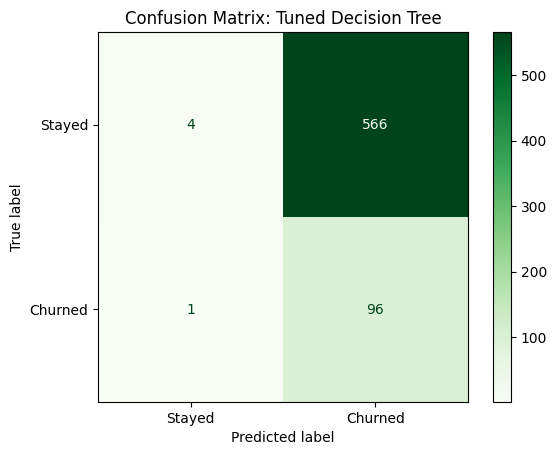

In [20]:
#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Define grid of setting to test
param_grid = {
    'max_depth': [3,5,7,10],
    'min_samples_leaf': [1,5,10],
    'criterion': ['gini', 'entropy']
}

#grid search
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)
#fitting
print ("Tuning the model...")
grid_search.fit(X_train_scaled, y_train)

#best parameters
best_tree = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

#evaluate best model
y_pred_best = best_tree.predict(X_test_clean)

print("\n--- Final tuned model results ---")
print(classification_report(y_test, y_pred_best))

#confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stayed", "Churned"])
disp.plot(cmap='Greens')
plt.grid(False)
plt.title("Confusion Matrix: Tuned Decision Tree")
plt.show()


As much as the linear regression model was too conservative and missed a lot of people, this model seems to be too aggressive since it flagged everyone.

## 5. Final Model Evaluation
We tested three models:
1.  **Logistic Regression:** Failed to detect churners (Recall: 0.11).
2.  **Decision Tree (Balanced):** Good balance (Recall: 0.57, Precision: 0.58).
3.  **Tuned Decision Tree:** Over-optimized for Recall (Recall: 0.99), resulting in extremely low precision (0.15).

**Conclusion:**
We select the **Balanced Decision Tree (Model 2)** as our final model. While Model 3 had the highest Recall, it achieved this by predicting "Churn" for almost everyone, which is not practical for a business (too many False Positives). Model 2 offers the best balance of catching churners while maintaining reasonable accuracy.

## 6. Recommendations for SyriaTel
Based on our analysis, we recommend:

1.  **The "3-Call" Alert System:**
    * **Finding:** Churn rate quadruples after a customer makes their 3rd service call.
    * **Action:** Implement a real-time alert. When a customer hangs up their 3rd call, automatically flag them for a "VIP Service Recovery" call from a manager.

2.  **International Plan Reform:**
    * **Finding:** Customers with International Plans churn at a much higher rate (42%).
    * **Action:** Audit the call quality for international lines and consider offering a "Traveler Loyalty Discount" to retain these high-value users.

3.  **Model Deployment:**
    * Use the **Balanced Decision Tree** model to score customers at the end of every billing cycle.
    * Focus retention offers on the top 20% of "At-Risk" customers identified by the model.